# Importation données

In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
from shapely import line_merge, MultiLineString
from shapely.geometry import Point, MultiPoint
from shapely.geometry import Polygon, MultiPolygon
import os
from shapely.geometry import LineString, MultiLineString, Point
from shapely.wkt import loads
from shapely.ops import linemerge
import ast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Chemin_Donnees_bornes : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/TMJA_2019_avec_bornes.csv"
df_trafic = pd.read_csv(Chemin_Donnees_bornes)

# Création du dataframe avec les routes fusionnées

In [ ]:
#Préparation du geoDataFrame
df_trafic['geometry'] = df_trafic['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)
df_trafic['borne_ids_proches'] = df_trafic['borne_ids_proches'].apply(
    lambda b: ast.literal_eval(b) if isinstance(b, str) else b
)
df_trafic['borne_ids_proches'] = df_trafic['borne_ids_proches'].apply(
    lambda b: [int(x) for x in b if isinstance(x, (int, str)) and str(x).isdigit()]
)
gdf_trafic = gpd.GeoDataFrame(df_trafic, geometry=df_trafic['geometry'], crs="EPSG:2154")

#Fonction intermediaires pour fusionner deux géométries
def fusionner_geometries(geom1, geom2):
    """
    Fusionne deux géométries (LineString ou MultiLineString).
    Si l'une des géométries est un MultiLineString, elle est décomposée.
    """
    geometries = []

    if isinstance(geom1, LineString):
        geometries.append(geom1)
    elif isinstance(geom1, MultiLineString):
        geometries.extend(geom1.geoms)
    if isinstance(geom2, LineString):
        geometries.append(geom2)
    elif isinstance(geom2, MultiLineString):
        geometries.extend(geom2.geoms)

    return linemerge(geometries)

#Fonction qui fusionne les routes, en appelant la fonction intermédiaire précédente
def fusionner_routes_par_proximite(df, distance_max=10000):
    """
    Fusionne les sections d'une même route selon la proximité (< distance_max).
    Si une section est trop éloignée, elle est ajoutée à un nouvel ensemble.
    """
    result = []

    for route, group in df.groupby('route'):
        ensembles = [] #stocke les ensembles de sections

        for _, row in group.iterrows():
            section_geom = row['geometry']
            xD, yD = row['xD'], row['yD']
            xF, yF = row['xF'], row['yF']

            section_added = False

            # Vérifier si cette section peut être ajoutée à un ensemble existant
            for ensemble in ensembles:
                last_geom = ensemble['geometry']


                if isinstance(last_geom, LineString):
                    last_point = Point(last_geom.coords[-1])
                elif isinstance(last_geom, MultiLineString):
                    last_point = Point(last_geom.geoms[-1].coords[-1])
                else:
                    continue

                #calcule la distance entre le dernier point et le début de la nouvelle section
                start_point = Point(xD, yD)
                distance = last_point.distance(start_point)

                #cas où on peut ajouter la section à l'ensemble
                if distance <= distance_max:
                    new_geom = fusionner_geometries(last_geom, section_geom)
                    ensemble['geometry'] = new_geom
                    ensemble['borne_ids'].update(
                        int(b) for b in row['borne_ids_proches'] if isinstance(b, (int, str)) and str(b).isdigit()
                    )
                    ensemble['length'] += row['longueur']
                    if not np.isnan(row['TMJA']):
                        ensemble['tmja_values'].append(row['TMJA'])
                    section_added = True
                    break
            #Cas où on doit créer un nouvel ensemble pour la section
            if not section_added:
                ensembles.append({
                    'route': route,
                    'geometry': section_geom,
                    'borne_ids': set(
                        int(b) for b in row['borne_ids_proches'] if isinstance(b, (int, str)) and str(b).isdigit()
                    ),
                    'length': row['longueur'],
                    'tmja_values': [row['TMJA']] if not np.isnan(row['TMJA']) else []
                })

        #pour ajuoter les ensembles créés au résultat
        for ensemble in ensembles:
            geom = ensemble['geometry']

            if isinstance(geom, LineString):
                start_point = geom.coords[0]
                end_point = geom.coords[-1]
            elif isinstance(geom, MultiLineString):
                start_point = geom.geoms[0].coords[0]
                end_point = geom.geoms[-1].coords[-1]
            else:
                continue

            result.append({
                'route': ensemble['route'],
                'longueur_totale': ensemble['length'],
                'point_depart_x': start_point[0],
                'point_depart_y': start_point[1],
                'point_fin_x': end_point[0],
                'point_fin_y': end_point[1],
                'borne_ids_proches': sorted(ensemble['borne_ids']),
                'tmja_m': np.mean(ensemble['tmja_values']) if ensemble['tmja_values'] else np.nan,
                'geometry': ensemble['geometry']
            })

    return gpd.GeoDataFrame(result, crs=df.crs)

gdf_routes_fusionnees = fusionner_routes_par_proximite(gdf_trafic)
print(gdf_routes_fusionnees)


           route  longueur_totale  point_depart_x  point_depart_y  \
0        31D0044             44.0     511656.7846    6.204078e+06   
1       31D0044E            762.0     511367.2150    6.204210e+06   
2        69D0301           6055.0     844036.8409    6.510806e+06   
3        69D0383          13752.0     846831.3025    6.522372e+06   
4    69D0383BPNL           2408.0     844982.4562    6.522772e+06   
..           ...              ...             ...             ...   
455        N1338           2060.0     560104.3940    6.927893e+06   
456        P0224           8995.0     555988.6130    6.288880e+06   
457        P0524           1777.0     440252.1000    6.361053e+06   
458        P0524           3860.0     458798.8530    6.325912e+06   
459        P0542           1536.0     548722.8430    6.283729e+06   

     point_fin_x   point_fin_y  \
0    511698.5087  6.204064e+06   
1    511880.7611  6.203732e+06   
2    849346.8894  6.509342e+06   
3    843537.8707  6.512430e+06   
4

In [ ]:
#Sauvegarde du résultat
gdf_routes_fusionnees.to_csv("/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/routes_fusionnees_tmja.csv")

18834284.00000002
18834284.0


# Vérification et exploration des données


In [ ]:
for i in range(len(gdf_routes_fusionnees)):
    # Filtrer les éléments dans 'borne_ids_proches' pour ne conserver que les entiers
    gdf_routes_fusionnees.at[i, "borne_ids_proches"] = [
        elt for elt in gdf_routes_fusionnees.at[i, "borne_ids_proches"] if isinstance(elt, int)
    ]



dateRefere        route  longueur  prD  depPrD concession         xD  \
0   2019-01-01      31D0044      44.0    0      31          N  511656.78   
1   2019-01-01     31D0044E     762.0    0      31          N  511367.22   
2   2019-01-01      69D0301    6055.0    2      69          N  844036.84   
3   2019-01-01      69D0383   13752.0    4      69          N  846831.30   
4   2019-01-01  69D0383BPNL    2408.0    0      69          N  844982.46   
5   2019-01-01     75000C01   35040.0    0      75          N  655221.44   
6   2019-01-01     75000C02   35040.0    0      75          N  655227.28   
7   2019-01-01        A0001    2440.0    0      93          N  653006.60   
8   2019-01-01        A0001     785.2    2      93          N  652895.68   
9   2019-01-01        A0001     401.8    3      93          N  653192.95   
10  2019-01-01        A0001     820.5    3      93          N  653570.77   
11  2019-01-01        A0001     229.5    4      93          N  654333.83   
12  2019-01-01        A0001     210.0    4      93          N  654554.12   
13  2019-01-01        A0001    2018.0    4      93          N  654759.06   
14  2019-01-01        A0001     102.0    6      93          N  656725.22   

            yD  prF  depPrF  ...   cumulF         xF          yF  anneeMesur  \
0   6204078.36    0      31  ...     44.0  511698.51  6204063.93        2019   
1   6204210.06    0      31  ...    762.0  511880.76  6203732.40        2019   
2   6510806.45    7      69  ...   6055.0  849346.89  6509342.34        2019   
3   6522372.16   17      69  ...  13752.0  843537.87  6512429.80        2019   
4   6522772.27    2      69  ...   2408.0  846831.30  6522372.16        2019   
5   6858722.80   35      75  ...  35040.0  655221.44  6858722.80        2019   
6   6858703.75   35      75  ...  35040.0  655227.28  6858703.75        2019   
7   6867037.55    2      93  ...   2440.0  652895.68  6869486.50        2019   
8   6869486.50    3      93  ...   3225.2  653192.95  6870100.70        2019   
9   6870100.70    3      93  ...   3627.0  653570.77  6870241.67        2019   
10  6870241.67    4      93  ...   4447.5  654333.83  6870523.68        2019   
11  6870523.68    4      93  ...   4677.0  654554.12  6870572.00        2019   
12  6870572.00    4      93  ...   4887.0  654759.06  6870596.05        2019   
13  6870596.05    6      93  ...   6905.0  656725.22  6870934.53        2019   
14  6870934.53    7      93  ...   7007.0  656820.85  6870967.75        2019   

    typeCompta         typeComp_1      TMJA  ratio_PL  \
0          NaN                NaN       NaN       0.0   
1          NaN                NaN       NaN       0.0   
2          NaN                NaN       NaN       0.0   
3          NaN                NaN       NaN       0.0   
4          NaN                NaN       NaN       0.0   
5          NaN                NaN       NaN       0.0   
6          NaN                NaN       NaN       0.0   
7          1.0  Permanent horaire  132186.0       0.0   
8          1.0  Permanent horaire  132186.0       0.0   
9          1.0  Permanent horaire  132186.0       0.0   
10         1.0  Permanent horaire  132186.0       0.0   
11         1.0  Permanent horaire  132186.0       0.0   
12         1.0  Permanent horaire  132186.0       0.0   
13         1.0  Permanent horaire  132757.0       0.0   
14         1.0  Permanent horaire  179900.0       0.0   

                                             geometry  \
0   LINESTRING (511656.785 6204078.361, 511672.731...   
1   MULTILINESTRING ((511367.215 6204210.064, 5113...   
2   LINESTRING (844036.841 6510806.45, 844044.447 ...   
3   LINESTRING (846831.303 6522372.16, 846865.124 ...   
4   LINESTRING (844982.456 6522772.273, 844995.417...   
5   LINESTRING (647256.052 6864493.522, 647272.326...   
6   LINESTRING (647240.12 6864501.655, 647254.344 ...   
7   LINESTRING (653006.597 6867037.547, 653006.017...   
8   LINESTRING (652895.678 6869486.499, 652892.672...   
9   LINESTRING (653192.

In [ ]:
import geopandas as gpd
from shapely.wkt import loads

Chemin_Donnees_trafic : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/routes_fusionnees_tmja.csv"
gdf_routes_fusionnees = pd.read_csv(Chemin_Donnees_trafic)


# Convertir la colonne 'geometry' en objets géométriques si nécessaire
gdf_routes_fusionnees['geometry'] = gdf_routes_fusionnees['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)

# Convertir en GeoDataFrame
gdf_routes_fusionnees = gpd.GeoDataFrame(gdf_routes_fusionnees, geometry=gdf_routes_fusionnees['geometry'], crs="EPSG:2154")

<ipython-input-5-c8b6877b42f4>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


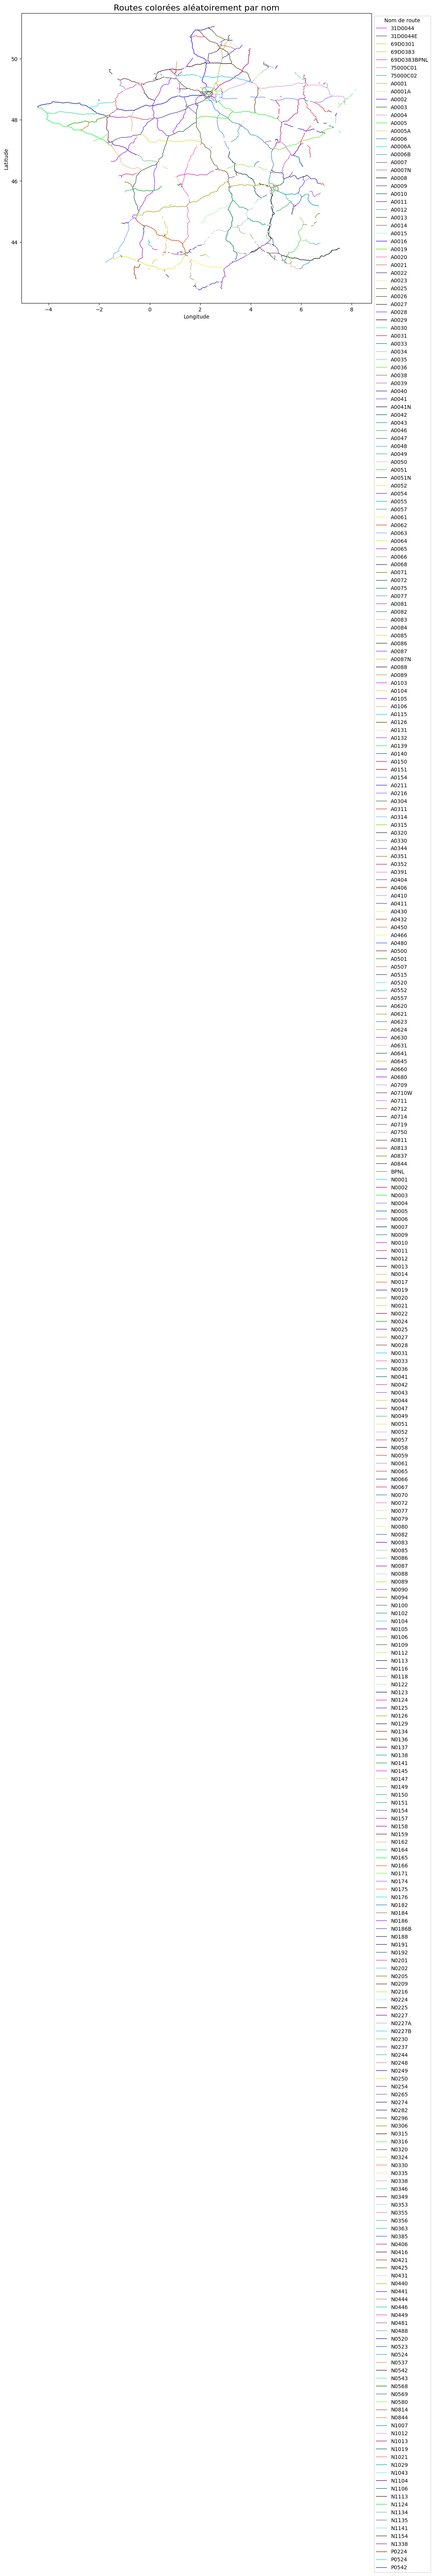

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.wkt import loads

# Préparer les données
gdf_routes_fusionnees['geometry'] = gdf_routes_fusionnees['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)
gdf_trafic = gpd.GeoDataFrame(gdf_routes_fusionnees, geometry=gdf_routes_fusionnees['geometry'], crs="EPSG:2154")

# Reprojection pour une meilleure visualisation
gdf_trafic = gdf_trafic.to_crs("EPSG:4326")

# Obtenir une liste unique des noms de routes
unique_names = gdf_trafic['route'].unique()

# Générer des couleurs aléatoires pour chaque nom de route
color_mapping = {name: f"#{random.randint(0, 0xFFFFFF):06x}" for name in unique_names}

# Tracer les routes
fig, ax = plt.subplots(figsize=(12, 10))
for _, row in gdf_trafic.iterrows():
    color = color_mapping[row['route']]
    if row['geometry'].geom_type == 'LineString':
        ax.plot(*row['geometry'].xy, color=color, linewidth=1, label=row['route'])
    elif row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:
            ax.plot(*line.xy, color=color, linewidth=1, label=row['route'])

# Légende unique
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Nom de route", loc='upper left', bbox_to_anchor=(1, 1))

# Personnalisation du graphique
ax.set_title("Routes colorées aléatoirement par nom", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


<ipython-input-6-e078c81dda45>:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


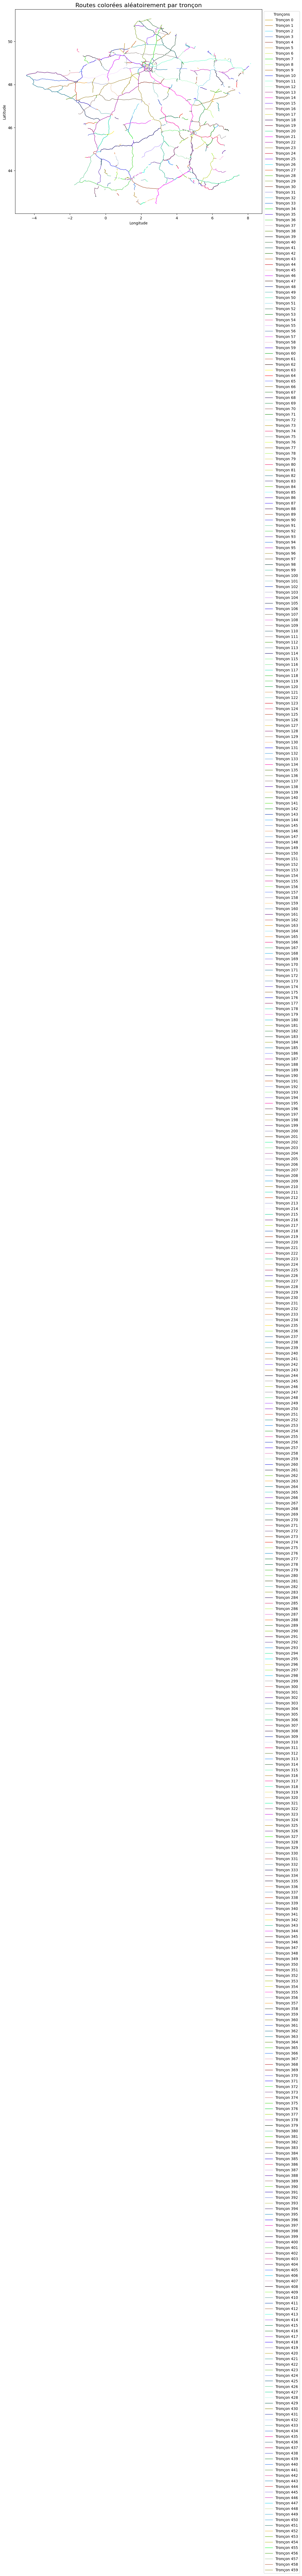

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.wkt import loads

# Préparer les données
gdf_routes_fusionnees['geometry'] = gdf_routes_fusionnees['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)
gdf_trafic = gpd.GeoDataFrame(gdf_routes_fusionnees, geometry=gdf_routes_fusionnees['geometry'], crs="EPSG:2154")

# Reprojection pour une meilleure visualisation
gdf_trafic = gdf_trafic.to_crs("EPSG:4326")

# Générer des couleurs aléatoires pour chaque tronçon
color_mapping = {index: f"#{random.randint(0, 0xFFFFFF):06x}" for index in gdf_trafic.index}

# Tracer les tronçons
fig, ax = plt.subplots(figsize=(12, 10))
for idx, row in gdf_trafic.iterrows():
    color = color_mapping[idx]
    if row['geometry'].geom_type == 'LineString':
        ax.plot(*row['geometry'].xy, color=color, linewidth=1, label=f"Tronçon {idx}")
    elif row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:
            ax.plot(*line.xy, color=color, linewidth=1, label=f"Tronçon {idx}")

# Légende unique
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Tronçons", loc='upper left', bbox_to_anchor=(1, 1))

# Personnalisation du graphique
ax.set_title("Routes colorées aléatoirement par tronçon", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


(array([200.,  14.,   8.,   3.,   2.,   0.,   0.,   0.,   0.,   4.]),
 array([4.04659677e-10, 1.17303719e-07, 2.34202779e-07, 3.51101838e-07,
        4.68000898e-07, 5.84899958e-07, 7.01799017e-07, 8.18698077e-07,
        9.35597136e-07, 1.05249620e-06, 1.16939526e-06]),
 <BarContainer object of 10 artists>)

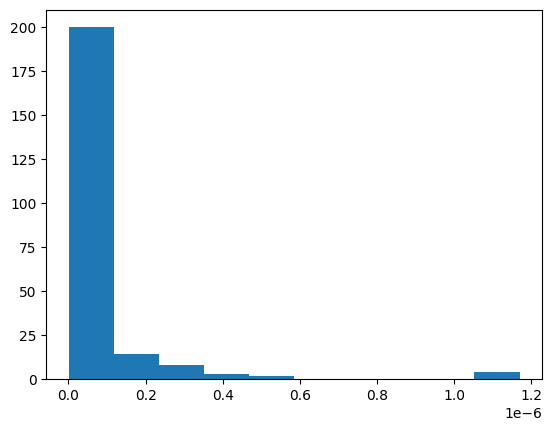

In [ ]:
table = gdf_routes_fusionnees

# Supposons que 'borne_ids_proches' est une liste d'identifiants pour chaque ligne.
# Calculer le nombre de bornes dans chaque portion
table['nombre_bornes'] = table['borne_ids_proches'].apply(lambda x: len(x))

# Calculer le nombre de bornes par mètre
table['longueur'] = pd.to_numeric(table['longueur_totale'], errors='coerce')

table['bornes_par_metre'] = table['nombre_bornes'] / table['longueur']

# Calculer le ratio bornes par mètre divisé par TMJA
table['tmja_m'] = pd.to_numeric(table['tmja_m'], errors='coerce')

table['ratio_bornes_TMJA'] = table['bornes_par_metre'] / table['tmja_m']

# Résultat
plt.hist(table['ratio_bornes_TMJA'])

In [ ]:
# df_trafic doit contenir une colonne 'route' pour lier les données
# Fusionner les données en fonction de la route
df_trafic_bis = df_trafic.merge(table[['route', 'ratio_bornes_TMJA']], on='route', how='left')

# Vérification
print(df_trafic_bis.head())


   dateRefere        route  longueur  prD  depPrD concession         xD  \
0  2019-01-01      31D0044      44.0    0      31          N  511656.78   
1  2019-01-01     31D0044E     762.0    0      31          N  511367.22   
2  2019-01-01      69D0301    6055.0    2      69          N  844036.84   
3  2019-01-01      69D0383   13752.0    4      69          N  846831.30   
4  2019-01-01  69D0383BPNL    2408.0    0      69          N  844982.46   

           yD  prF  depPrF  ...         xF          yF  anneeMesur  \
0  6204078.36    0      31  ...  511698.51  6204063.93        2019   
1  6204210.06    0      31  ...  511880.76  6203732.40        2019   
2  6510806.45    7      69  ...  849346.89  6509342.34        2019   
3  6522372.16   17      69  ...  843537.87  6512429.80        2019   
4  6522772.27    2      69  ...  846831.30  6522372.16        2019   

   typeCompta  typeComp_1  TMJA ratio_PL  \
0         NaN         NaN   NaN      0.0   
1         NaN         NaN   NaN      0.0

<ipython-input-121-6e408b40e3ec>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


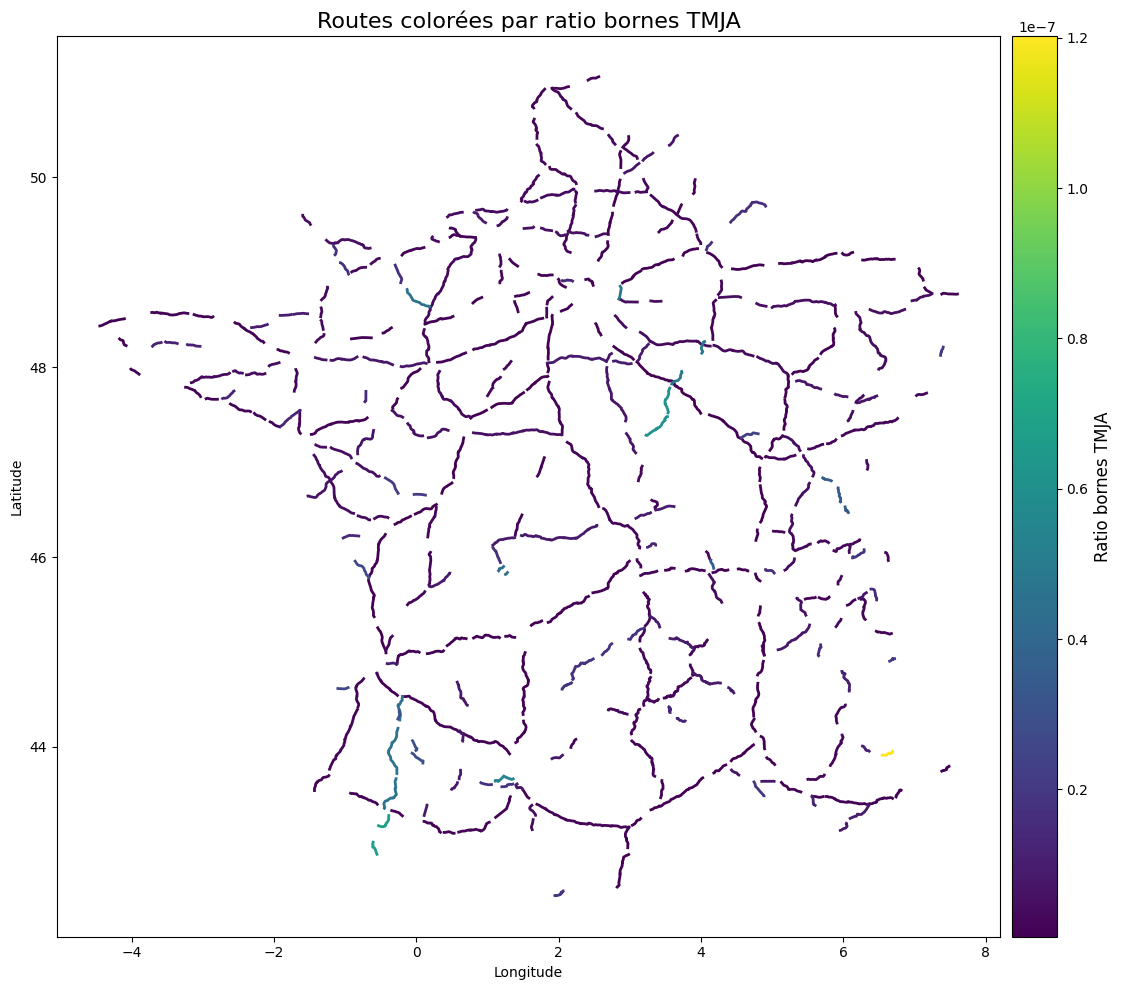

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from shapely.wkt import loads

# Préparer les données
df_trafic_bis['geometry'] = df_trafic_bis['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)
df_trafic_bis = df_trafic_bis[df_trafic_bis["longueur"]>10000]
gdf_trafic = gpd.GeoDataFrame(df_trafic_bis, geometry=df_trafic_bis['geometry'], crs="EPSG:2154")

# Vérifier les géométries et les ratios
gdf_trafic = gdf_trafic[gdf_trafic['geometry'].notnull()]  # Supprimer les géométries nulles
gdf_trafic = gdf_trafic[gdf_trafic['ratio_bornes_TMJA'].notnull()]  # Supprimer les valeurs NaN de ratio
if gdf_trafic['ratio_bornes_TMJA'].nunique() == 1:
    print("Toutes les routes ont le même ratio_bornes_TMJA.")

# Reprojection pour une meilleure visualisation
gdf_trafic = gdf_trafic.to_crs("EPSG:4326")

# Normaliser les valeurs de 'ratio_bornes_TMJA' pour les mapper à une palette de couleurs
norm = Normalize(vmin=gdf_trafic['ratio_bornes_TMJA'].min(), vmax=gdf_trafic['ratio_bornes_TMJA'].max())
cmap = cm.get_cmap('viridis')

# Tracer les routes
fig, ax = plt.subplots(figsize=(12, 10))
for _, row in gdf_trafic.iterrows():
    color = cmap(norm(row['ratio_bornes_TMJA']))
    if row['geometry'].geom_type == 'LineString':
        ax.plot(*row['geometry'].xy, color=color, linewidth=2)
    elif row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:
            ax.plot(*line.xy, color=color, linewidth=2)

# Ajouter une barre de couleur
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
cbar.set_label('Ratio bornes TMJA', fontsize=12)

# Personnalisation du graphique
ax.set_title("Routes colorées par ratio bornes TMJA", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


In [ ]:
#borne/TMJA par dep
Chemin_Donnees_bornes : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/TMJA_2019_avec_bornes.csv"
df_trafic = pd.read_csv(Chemin_Donnees_bornes)

# Calcul du TMJA moyen par département
tmja_par_departement = df_trafic.groupby('depPrD')['TMJA'].mean().reset_index()

# Renommer les colonnes pour plus de clarté
tmja_par_departement.columns = ['depPrD', 'TMJA_moyen']

# Afficher le résultat
print(tmja_par_departement)


    depPrD     TMJA_moyen
0        1   33590.309524
1        2   21064.583333
2        3   11773.794118
3        4    6236.038462
4        5   10054.460000
..     ...            ...
89      91   64850.619048
90      92   73716.250000
91      93  136675.440000
92      94  113175.555556
93      95   87498.740741

[94 rows x 2 columns]
